In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import segmentation_models_pytorch as smp
import torch
import torchvision

from pathlib import Path
from segmentation_models_pytorch import utils as smp_utils
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary


%matplotlib inline

In [2]:
torch.__version__

'1.9.1+cu102'

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name()

'NVIDIA GeForce MX250'

#### Load Data

In [3]:
DATA_ROOT = 'D:/Data/Study/set-lipstick-original/'

In [4]:
mask = plt.imread(DATA_ROOT + 'mask/mask00000001.png')
img = plt.imread(DATA_ROOT + '720p/image00000001.jpg')

(720, 1280, 3)

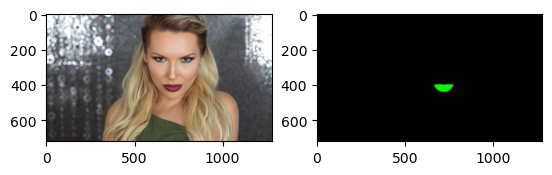

In [8]:
figure, ax = plt.subplots(nrows=1, ncols=2)
ax.ravel()[0].imshow(img)
ax.ravel()[1].imshow(mask)
plt.show
mask.shape

In [5]:
df_img = pd.read_csv(DATA_ROOT + 'list.csv')
df_img

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png
...,...,...,...,...,...,...,...,...,...
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png


In [6]:
df_img['class'].describe()

count     28594
unique        1
top        Lips
freq      28594
Name: class, dtype: object

In [7]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   width     28594 non-null  int64 
 2   height    28594 non-null  int64 
 3   class     28594 non-null  object
 4   xmin      28594 non-null  int64 
 5   ymin      28594 non-null  int64 
 6   xmax      28594 non-null  int64 
 7   ymax      28594 non-null  int64 
 8   mask      28594 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [8]:
df_img = df_img[['filename', 'mask']]
df_img.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [9]:
list_imgs = sorted([i for i in Path(DATA_ROOT + '720p').iterdir()])
list_masks = sorted([i for i in Path(DATA_ROOT + 'mask').iterdir()])
len(list_imgs), len(list_masks)

(28594, 28540)

In [10]:
df_img = df_img.loc[df_img['mask'].isin([i.name for i in list_masks])]
df_img.reset_index(drop=True, inplace=True)
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


#### Prepare a class for a custom dataset

In [11]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Serve our prepared dataframe
        self.data = data
        
        # Divide the dataframe into rgb images
        self.image_arr = self.data.iloc[:,0]
        # and segmented pictures
        self.label_arr = self.data.iloc[:,1]
        
        # Number of picture-segmentation pairs
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Read the picture 
        img = cv2.cvtColor(cv2.imread(DATA_ROOT + '720p/' + self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
           # Normalize the image in values [0, 1]
            img = torch.as_tensor(img).to(device) / 255.0
        img = img.permute(2,0,1)
        
        # read the segmented image
        mask = cv2.cvtColor(cv2.imread(DATA_ROOT + 'mask/' + self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
            
        masks = torch.as_tensor(masks).to(device)  
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

#### Initialize Unet

In [16]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.contracting_11(X) # [-1, 64, 256, 256]
        x2 = self.contracting_12(x1) # [-1, 64, 128, 128]
        x3 = self.contracting_21(x2) # [-1, 128, 128, 128]
        x4 = self.contracting_22(x3) # [-1, 128, 64, 64]
        x5 = self.contracting_31(x4) # [-1, 256, 64, 64]
        x6 = self.contracting_32(x5) # [-1, 256, 32, 32]
        x7 = self.contracting_41(x6) # [-1, 512, 32, 32]
        x8 = self.contracting_42(x7) # [-1, 512, 16, 16]
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.expansive_11(x) # [-1, 512, 32, 32]
        x = self.expansive_12(torch.cat((x, x7), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        x = self.expansive_21(x) # [-1, 256, 64, 64]
        x = self.expansive_22(torch.cat((x, x5), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        x = self.expansive_31(x) # [-1, 128, 128, 128]
        x = self.expansive_32(torch.cat((x, x3), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        x = self.expansive_41(x) # [-1, 64, 256, 256]
        x = self.expansive_42(torch.cat((x, x1), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [12]:
X_train, X_test = train_test_split(df_img, test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [13]:
train_data_loader = DataLoader(train_data, 
                               batch_size=8,
                               shuffle=True)
test_data_loader = DataLoader(test_data,
                              batch_size=4,
                              shuffle=False)

In [20]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

### Initialize Unet with a pre-trained by imagenet resnet50 encoder with sigmoid activation

In [25]:
# model creation
BACKBONE = 'resnet50'
model = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

#### Freeze encoder weights

In [26]:
for param in list(model.encoder.parameters())[:]:
    param.requires_grad = False

In [27]:
summary(model.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

#### Initialize the loss function, metric and optimizer with trainable parameters

In [28]:
criterion = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(),]

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [29]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

#### Train and valid the model

In [30]:
max_score = 0
for i in range(2):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████████████████████████| 2141/2141 [12:40<00:00,  2.82it/s, dice_loss - 0.04771, iou_score - 0.9126]
Model saved!
Epoch: 2
valid: 100%|██████████████████████████████| 2141/2141 [11:32<00:00,  3.09it/s, dice_loss - 0.03765, iou_score - 0.9284]
Model saved!


## train: dice_loss - 0.03712, iou_score - 0.9295
## valid: dice_loss - 0.03765, iou_score - 0.9284

In [52]:
data_iter = iter(test_data_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

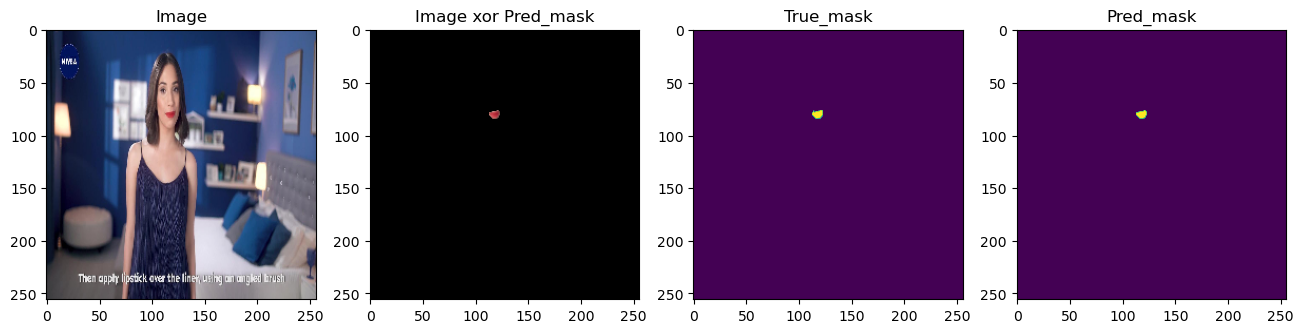

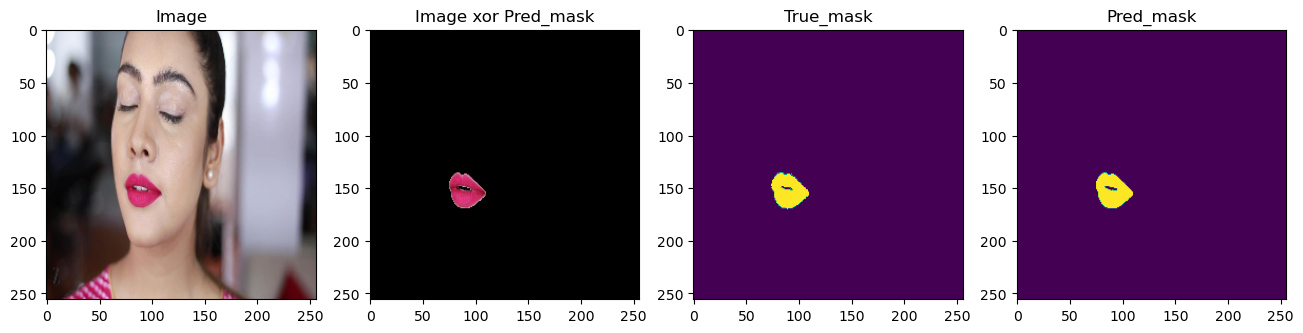

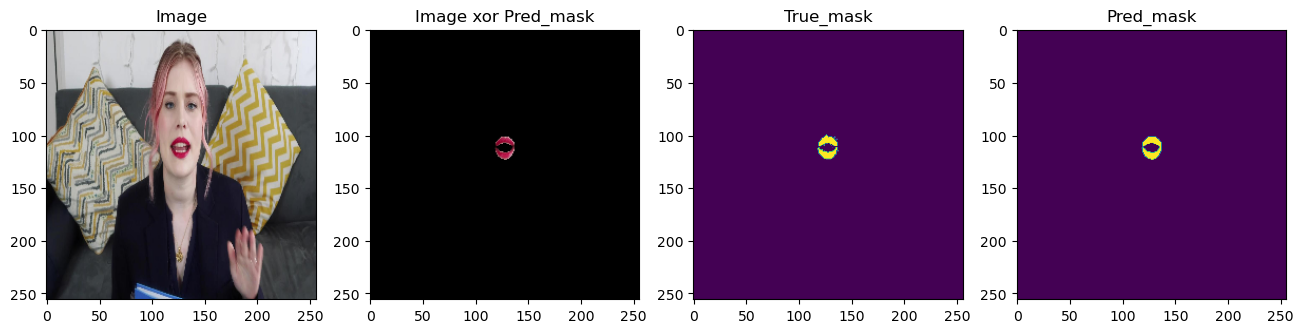

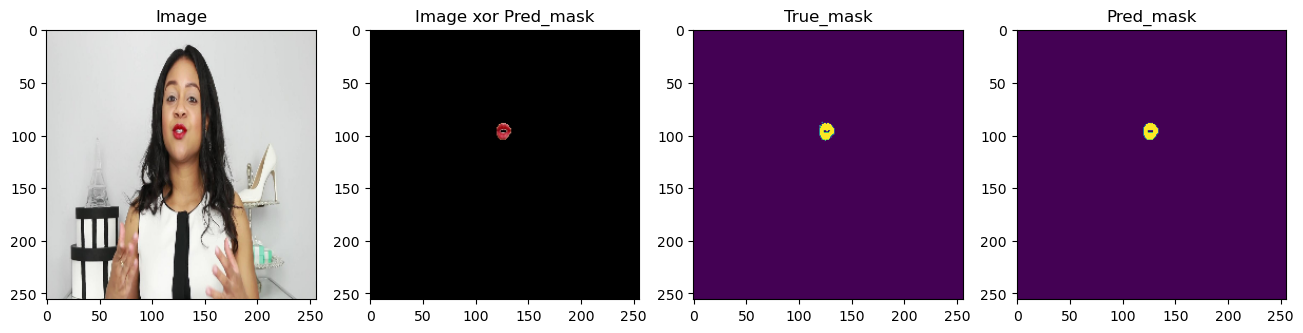

In [53]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(image.cpu()*outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_2.set_title('Image xor Pred_mask')
    
    ax_3.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('True_mask')
    
    ax_4.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_4.set_title('Pred_mask')

### Initialize PSPNet with a pre-trained by imagenet mobilenet_v2 encoder with sigmoid activation

In [17]:
# model creation
BACKBONE = 'mobilenet_v2'
model = smp.PSPNet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

#### Freeze encoder weights

In [18]:
for param in list(model.encoder.parameters())[:]:
    param.requires_grad = False

In [19]:
summary(model.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
             ReLU6-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
             ReLU6-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]             512
       BatchNorm2d-8         [-1, 16, 128, 128]              32
  InvertedResidual-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 96, 128, 128]           1,536
      BatchNorm2d-11         [-1, 96, 128, 128]             192
            ReLU6-12         [-1, 96, 128, 128]               0
           Conv2d-13           [-1, 96, 64, 64]             864
      BatchNorm2d-14           [-1, 96,

#### Initialize the loss function, metric and optimizer with trainable parameters

In [20]:
criterion = smp_utils.losses.DiceLoss()
metrics = [smp_utils.metrics.IoU(),]

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [21]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

#### Train and valid the model

In [22]:
max_score = 0
for i in range(4):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_mobile_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|████████████████████████████████| 2141/2141 [09:00<00:00,  3.96it/s, dice_loss - 0.1365, iou_score - 0.769]
Model saved!
Epoch: 2
valid: 100%|███████████████████████████████| 2141/2141 [08:18<00:00,  4.30it/s, dice_loss - 0.1267, iou_score - 0.7828]
Model saved!
Epoch: 3
valid: 100%|███████████████████████████████| 2141/2141 [08:20<00:00,  4.28it/s, dice_loss - 0.1195, iou_score - 0.7928]
Model saved!
Epoch: 4
valid: 100%|███████████████████████████████| 2141/2141 [08:15<00:00,  4.32it/s, dice_loss - 0.1162, iou_score - 0.7974]
Model saved!


## train: dice_loss - 0.1126, iou_score - 0.8024
## valid: dice_loss - 0.1162, iou_score - 0.7974

In [23]:
data_iter = iter(test_data_loader)
images, labels = data_iter.next()
images, labels = images.to(device), labels.to(device)

outputs = model(images)

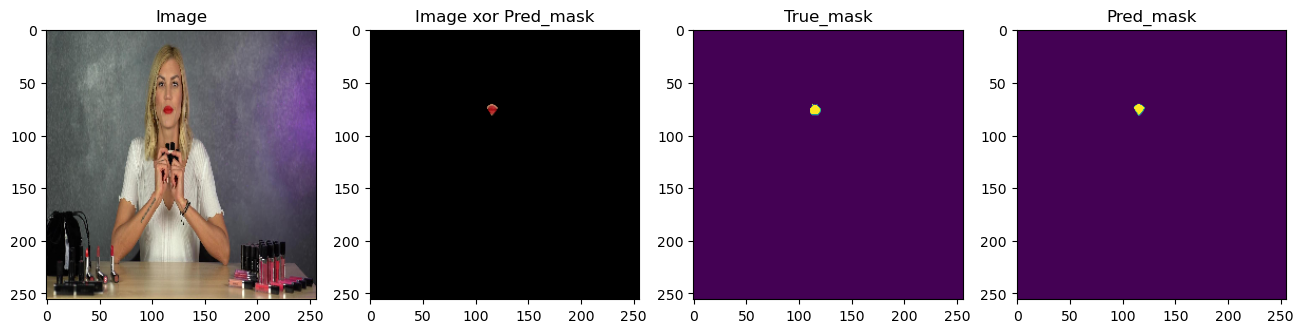

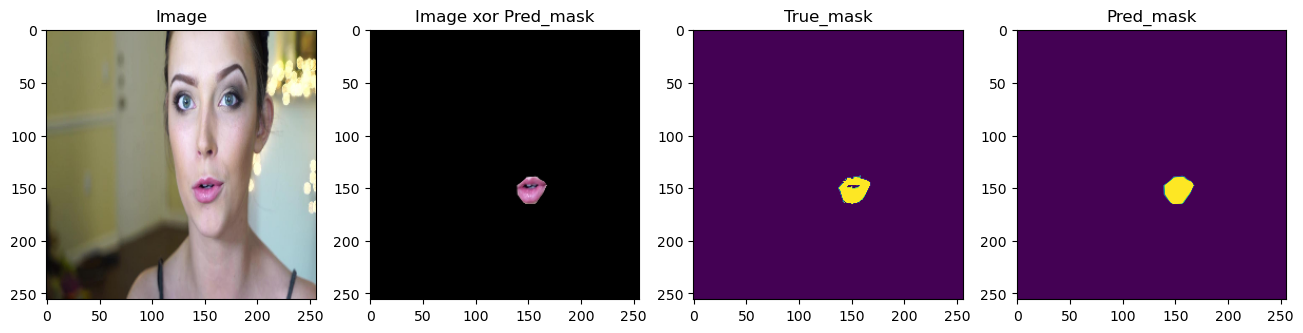

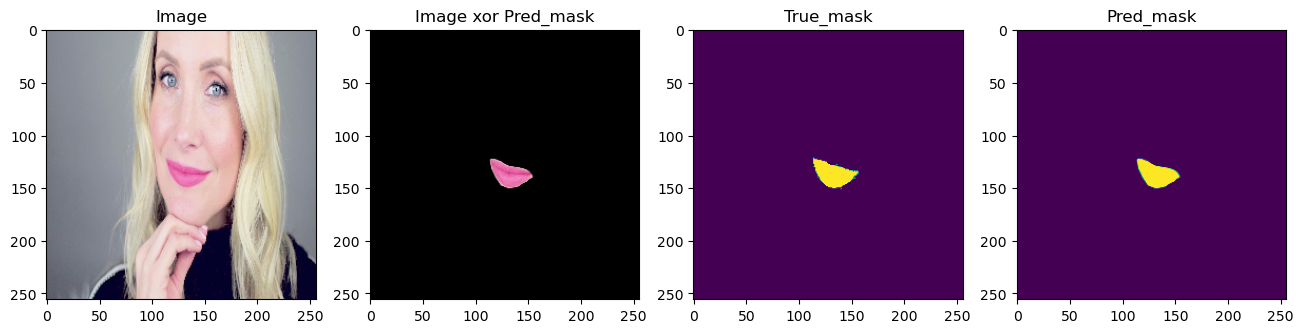

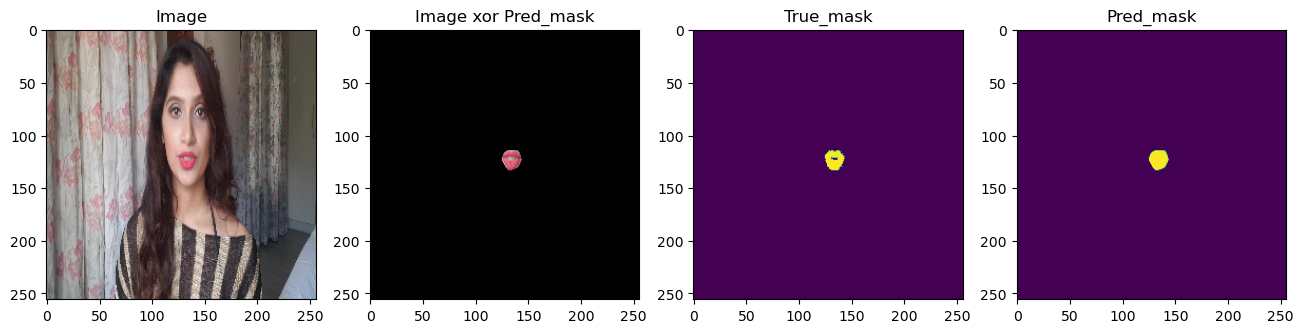

In [24]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3, ax_4) = plt.subplots(1, 4, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(image.cpu()*outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_2.set_title('Image xor Pred_mask')
    
    ax_3.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('True_mask')
    
    ax_4.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_4.set_title('Pred_mask')